In [1]:
##Import some modules used for this notebook.
from get_save_directory import get_save_dir
from make_dataset import make_dataset
from normalization import Normalization
from make_train_test_dataset import MakeTrainTestDataset
from artificial_neural_network_gpu import ArtificialNeuralNetwork
from interpolate import interpolate
from relative_error import relative_error
from about_directory import about_dir
import os, sys, shutil
import numpy as np
import copy as cp
import pickle

In [2]:
##Print a dir_list which is a list of ectracted parameters.
##The parameters are made by ./parameter/MakePickleOfParam.ipynb.
dir_list = np.loadtxt("param_list.txt", dtype = "str")
for i in range(len(dir_list)):
    if i == 0:
        print(dir_list[i])
    else:
        print("{}. {}".format(i, dir_list[i]))

--Parameters--
1. param_1e+7_1e+18_ScaleFactor_ID_pid_Mvir_Rvir_x_vx_MW039_MW038_MW035_MW034_MW033_MW032.pickle


In [3]:
##Input index-number of param_list.txt in dir_num to select it.
##Load the parameters of host-halo and sub-halo.
dir_num = int(input("\nSelect index>> "))
with open("parameters/" + dir_list[dir_num], mode = "rb") as f:
    param = pickle.load(f)
with open("parameters/host_" + dir_list[dir_num], mode = "rb") as f:
    host_param = pickle.load(f)


Select index>> 1


In [4]:
##The list of used parameters and host-halo.
param_list = list(param.keys())
mainbranch_list = list(param[param_list[0]].keys())
print("parameters : {}".format(param_list))
print("files : {}".format(mainbranch_list))

parameters : ['ScaleFactor', 'ID', 'pid', 'Mvir', 'Rvir', 'x', 'vx']
files : ['mainbranch_MW039.csv', 'mainbranch_MW038.csv', 'mainbranch_MW035.csv', 'mainbranch_MW034.csv', 'mainbranch_MW033.csv', 'mainbranch_MW032.csv']


In [5]:
##Get zacc of each sub-halo as acc_sf(Data type is dictionary).
##The zacc is a time when ID of host-halo and pid of sub-halo match.
acc_sf = {}
for m_key in mainbranch_list:
    acc_sf[m_key] = []
    for idx, parameter in enumerate(param["pid"][m_key]):
        for i in range(parameter.size):
            host_i = host_param["ID"][m_key].size - parameter.size + i
            if host_param["ID"][m_key][host_i] == parameter[i]:
                acc_sf[m_key].append(i)
                break
            elif i == parameter.size-1:
                acc_sf[m_key].append(-1)

In [23]:
##Describe variables of learning-parameter of a DeepLearningModel in LearnParam.
class LearnParam:
    def __init__(self):
        self.eps = 1e-7  ##Prevent devision by zero like 1 / (0 + eps).
        self.bias = False ##If This bias is True, add normalized dataset to bias.
        self.hidden = [1000]*10  ##Defines number of hidden layers and neurons in each layers.
        self.batchsize_denominator = 100  ##Defines a size of mini-batch as size(train-dataset) /  batch_denominator.
        self.learning_rate = "1e-3"  ##Learning rate of Back propagation.
        self.optimizer = "Adam"  ##Optimizer of the DeepLearningModel.
        self.batch_normalization = True  ##Whether to use BatchNormalization or not.
        self.loss_func = "MSE_RE"  ##Loss function of a DeepLearning model.
        self.activation_func = "tanhexp"  ##Activation function of the hidden layers.
        self.weight_init = "he"  ##Condition for initializing weight of the hidden layers.
        self.lastlayer_identity = True
        self.epoch = 200  ##Training epoch.
        self.input_size = 2  ##Size of input-dataset(axis == 1)
        self.output_size = 7  ##Size of output-dataset(axis == 1)
        self.param_kind = "x"  ##Learning parameter.
        self.train_ratio = 0.9  ##Percentage of training-dataset to all-dataset.
        self.normalize_format = "Standardization"  ##Selects a format of dataset normalization in None, Normalization, Standardization.
        self.extract_dataset = "After_acc"  ##Selects a condition of dataset.
        ##All is overall, Before/After_acc is in part of before/after accretion, All(_not)_acc is overall of (not)accreted sub-halo.
        self.learn_num = 4  ##Distinguishes each directories where training results are saved.
        self.save_fig_type = ".png"  ##Format of the saved figures.

In [24]:
LP = LearnParam()
save_dir = get_save_dir(LP)
if os.path.isdir(save_dir):
    print("Warning!\nThis directory \"{0}\" is an existing directory.\nIt will be overwritten.".format(save_dir))

In [25]:
dataset = make_dataset(mainbranch_list, LP.param_kind, host_param, param, LP.extract_dataset, acc_sf, LP.input_size, LP.output_size)
MTTD = MakeTrainTestDataset(mainbranch_list)
train, test = MTTD.split(cp.deepcopy(dataset), LP.train_ratio)

In [26]:
ANN = ArtificialNeuralNetwork(LP.input_size, LP.hidden, LP.activation_func, LP.weight_init, LP.batch_normalization, LP.output_size, LP.lastlayer_identity, LP.loss_func, is_epoch_in_each_mlist = False)

In [27]:
%%timeit -n 1 -r 1
ANN.learning(cp.deepcopy(train), cp.deepcopy(test), LP.optimizer, LP.learning_rate, LP.batchsize_denominator, LP.epoch, mainbranch_list, LP.normalize_format)

Make a train/test dataset.
Train dataset size : 3988
Test dataset size : 465
Mini-batch size : 39
Iterations per 1epoch : 102
Iterations : 20400
0epoch.
loss_val : 305.78986546313104
train_acc : 15.720248788354416
test_acc : 15.576529628567778
10epoch.
loss_val : 0.18374471646644458
train_acc : 0.27457887967933337
test_acc : 0.22231275730313874
20epoch.
loss_val : 0.008823706779248814
train_acc : 0.06674209204975451
test_acc : 0.07602583559578825
30epoch.
loss_val : 0.009445248728260976
train_acc : 0.07949055455980274
test_acc : 0.08870940534948078
40epoch.
loss_val : 0.013787877630628385
train_acc : 0.0960153409935789
test_acc : 0.10113526679614276
50epoch.
loss_val : 0.008327003677519837
train_acc : 0.07161928109219176
test_acc : 0.0692546860720882
60epoch.
loss_val : 0.005744254131833555
train_acc : 0.05333980168985095
test_acc : 0.060242922699657836
70epoch.
loss_val : 0.018301862914995127
train_acc : 0.09516815901139855
test_acc : 0.09266835294499641
80epoch.
loss_val : 0.00793680

In [28]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    print("Make a directory {}.".format(save_dir))

Make a directory 2in_7out/x_10layers_1000neurons_BatchNorm_MSE_RE_1e-3lr_200epoch_Standardization_After_acc_4/.


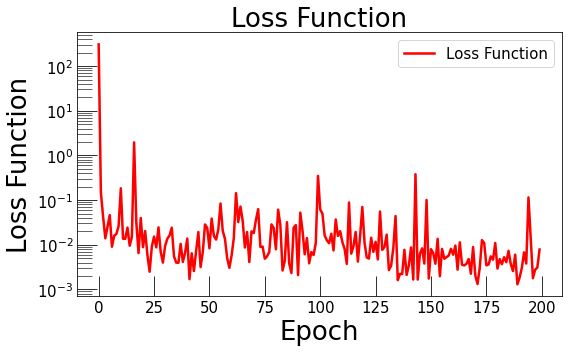

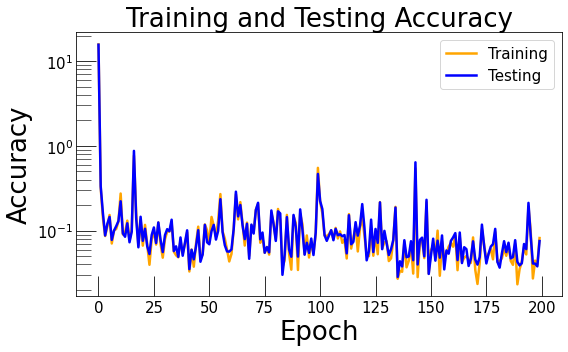

In [29]:
ANN.plot_figures(save_dir, LP.save_fig_type)

In [30]:
interpolate_methods = ["origin", "ann", "linear", "cubic"]
#interp_normed, interp_inv = {}, {}
interp = {}
for ip_key in interpolate_methods:
    #pred_normed, pred_inv = None, None  ##Initialize.
    pred = None  ##Initialize
    if ip_key == "origin":
        pred = dataset
    if ip_key == "ann":
        pred = ANN.predict(cp.deepcopy(dataset))
    if ip_key == "linear" or ip_key == "cubic":
        pred = interpolate(dataset, LP.input_size, LP.output_size, ip_key)
    interp[ip_key] = pred

In [31]:
with open(save_dir + "interp.pickle", mode = "wb") as f:
    pickle.dump(interp, f)

In [32]:
scale_factor = make_dataset(mainbranch_list, "ScaleFactor", host_param, param, LP.extract_dataset, acc_sf, LP.input_size, LP.output_size)
with open(save_dir + "scale_factor.pickle", mode = "wb") as f:
    pickle.dump(scale_factor, f)

In [33]:
about_dir(save_dir, mainbranch_list, dir_list[dir_num], LP)

In [34]:
with open("directory_list.txt", mode = "a") as f:
    f.writelines(save_dir + "\n")